# Covid-19 and Pneumonia Classification with Deep Learning

We are a researcher in a hospital lab and are given the task to develop a learning model that supports doctors with diagnosing illnesses that affect patients’ lungs.

We hope this model can help doctors with the challenge of deciphering X-ray scans and open a dialogue between your research team and the medical staff to create learning models that are as effective and interpretable as possible.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout,InputLayer,Conv2D,Dense,MaxPooling2D,Flatten
from tensorflow.keras.metrics import CategoricalAccuracy,AUC
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

In [4]:
#Constructing an ImageDataGenerator object:
DIRECTORY_TRAIN = "/content/drive/MyDrive/Covid19-dataset/train"
DIRECTORY_TEST = "/content/drive/MyDrive/Covid19-dataset/test"

CLASS_MODE = "categorical"
COLOR_MODE = "grayscale"
TARGET_SIZE = (256,256)
BATCH_SIZE = 32
# For Data Generating as well as data Augmentation Because of small Dataset
training_data_generator = ImageDataGenerator(rescale=1.0/255,

#Randomly increase or decrease the size of the image by up to 10%
zoom_range=0.1, 

#Randomly rotate the image between -25,25 degrees
rotation_range=25, 

#Shift the image along its width by up to +/- 5%
width_shift_range=0.05, 

#Shift the image along its height by up to +/- 5%
height_shift_range=0.05,

)

validation_data_generator = ImageDataGenerator()

training_iterator = training_data_generator.flow_from_directory(DIRECTORY_TRAIN,class_mode='categorical',color_mode='grayscale',batch_size=BATCH_SIZE)#, subset='training')

training_iterator.next()

print("\nLoading validation data...")


validation_iterator = validation_data_generator.flow_from_directory(DIRECTORY_TEST,class_mode='categorical', color_mode='grayscale',batch_size=BATCH_SIZE)#, subset='validation')


Found 251 images belonging to 3 classes.

Loading validation data...
Found 66 images belonging to 3 classes.


In [5]:
print("\nBuilding model...")

def design_model(training_data):
    # sequential model
    model = Sequential()
    # add input layer with grayscale image shape
    model.add(tf.keras.Input(shape=(256, 256, 1)))
    # convolutional hidden layers with relu functions
    # maxpooling layers and dropout layers as well
    model.add(Conv2D(5, 3, strides=3, activation="relu")) 
    model.add(MaxPooling2D(
        pool_size=(2, 2), strides=(2,2)))
    model.add(Dropout(0.1))
    model.add(Conv2D(5, 3, strides=1, activation="relu")) 
    model.add(MaxPooling2D(
        pool_size=(2, 2), strides=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(3, 3, strides=1, activation="relu")) 
    model.add(MaxPooling2D(
        pool_size=(2, 2), strides=(1,1)))
    model.add(Dropout(0.1))
    
    # experimenting with extra layesr
    #model.add(tf.keras.layers.Conv2D(3, 3, strides=1, activation="relu"))
    #model.add(tf.keras.layers.Conv2D(1, 1, strides=1, activation="relu"))
    #model.add(tf.keras.layers.Dropout(0.1))
    model.add(Flatten())
    # output layer with softmax activation function
    model.add(Dense(3,activation="softmax"))
    # compile model with Adam optimizer
    # loss function is categorical crossentropy
    # metrics are categorical accuracy and AUC
    print("\nCompiling model...")
    model.compile(optimizer=Adam(learning_rate=.001), loss=CategoricalCrossentropy(), metrics=[CategoricalAccuracy(),AUC()],)
    # summarize model
    model.summary()
    return model    


Building model...


In [6]:
# use model function
model = design_model(training_iterator)

# early stopping implementation
es = EarlyStopping(monitor='val_auc', mode='min', verbose=1, patience=20)

print("\nTraining model...")
# fit the model with 10 ephochs and early stopping
history =model.fit(
        training_iterator,
        steps_per_epoch=training_iterator.samples/BATCH_SIZE, epochs=5,
        validation_data=validation_iterator,
        # validation_steps=validation_iterator.samples/BATCH_SIZE
        callbacks=[es])


Compiling model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 85, 85, 5)         50        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 42, 5)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 42, 42, 5)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 5)         230       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 5)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 

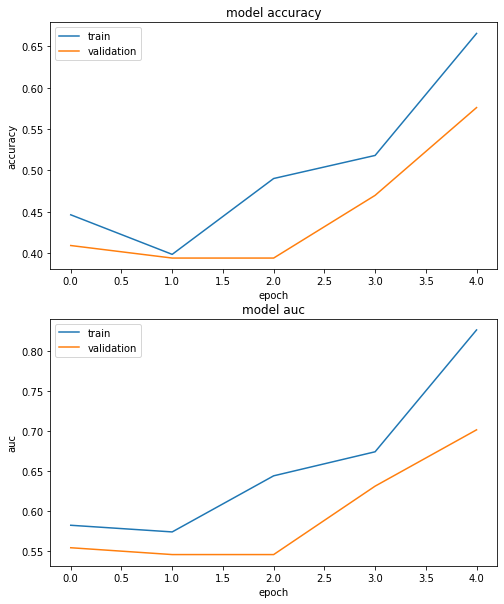

In [8]:

# plotting categorical and validation accuracy over epochs
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(history.history['categorical_accuracy'])
ax1.plot(history.history['val_categorical_accuracy'])
ax1.set_title('model accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.legend(['train', 'validation'], loc='upper left')

# plotting auc and validation auc over epochs
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(history.history['auc'])
ax2.plot(history.history['val_auc'])
ax2.set_title('model auc')
ax2.set_xlabel('epoch')
ax2.set_ylabel('auc')
ax2.legend(['train', 'validation'], loc='upper left')

plt.show()

In [9]:
# Finding the f1-score is helpful way to evaluate our model based on how badly it makes flase negative mistakes.
predictions = model.predict(validation_iterator)
prediction_classes = np.argmax(predictions, axis=1)
true_classes = validation_iterator.classes
report = classification_report(true_classes,prediction_classes)
print(report)

              precision    recall  f1-score   support

           0       0.36      0.73      0.48        26
           1       0.33      0.10      0.15        20
           2       0.14      0.05      0.07        20

    accuracy                           0.33        66
   macro avg       0.28      0.29      0.24        66
weighted avg       0.29      0.33      0.26        66



Ive figured that the sample size for this project is pretty small only 250 images.
So, the accuracy seems low but for 3 classes accuracy of 33% is still good.